In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score,ShuffleSplit
from sklearn.metrics import accuracy_score,mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,ExtraTreesClassifier
from sklearn.decomposition import PCA, KernelPCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.feature_selection import SelectKBest,SelectFromModel,f_classif
#from mlxtend.plotting import plot_decision_regions

In [8]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# DataSet

In [9]:
df=pd.DataFrame(pd.read_csv('../top_Gads_updated.dat',header=None, comment="#",sep='\s+',
                            squeeze=True, names=["material","adsorbate","DF_lower","DF_upper","DF"]))

df=df[['material', 'adsorbate','DF']]
aminoacid=df["adsorbate"].unique()

n={}
for i in aminoacid:
    n[i]=list(df[df.adsorbate==i]['DF'])    
X=pd.DataFrame(n)

X.head(5) 
print(X.shape)
aminoacids_label=list(df["adsorbate"].unique())
material_label=list(df["material"].unique())

(33, 32)


# Data Preparation

In [10]:
X.rename(columns={'C3H6': 'PRP','C4H6': 'BUT-2','C4H8': 'BUT-1'}, inplace=True)
X.rename(index={'C_amorph-1':'C-AM-1', 'C_amorph-2':'C-AM-2', 'C_amorph-3':'C-AM-3',
                'CNT15-COO--10':'CNT-COO$^{-}$-high','CNT15-COO--3':'CNT-COO$^{-}$-low',
                'CNT15-COOH-30':'CNT-COOH-high', 'CNT15-COOH-3':'CNT-COOH-low', 
                'CNT15-NH2-14':'CNT-NH$_{2}$-high', 'CNT15-NH2-2':'CNT-NH$_{2}$-low',
                'CNT15-NH3+-4':'CNT-NH$_{3}^{+}$-high', 'CNT15-NH3+-2':'CNT-NH$^{+}_{3}$-low',
                'CNT15-OH-14':'CNT-OH-high', 'CNT15-OH-4':'CNT-OH-low',
                'CNT15':'CNT', 'Fe2O3-001O':'Fe$_{2}$O$_{3}$(001)',
                'graphene':'GR', 'bi-graphene':'bi-GR', 'tri-graphene':'tri-GR', 'grapheneoxide': 'GO', 'redgrapheneoxide': 'rGO',
                'SiO2-Q2': 'SiO$_{2}$-Q2', 'SiO2-Q4':'SiO$_{2}$-Q4',
                'TiO2-rut-110':'TiO$_{2}$-rut(110)' , 'TiO2-ana-101': 'TiO$_{2}$-ana(101)',
                'TiO2-rut-100':'TiO$_{2}$-rut(100)', 'TiO2-ana-100':'TiO$_{2}$-ana(100)', 
                'TiO2-ana-101-NB':'TiO$_{2}$-ana(101)-NB', 
                'ZnO-1010':'ZnO(10$\overline{1}}$0)', 'ZnO-1210':'ZnO(1$\overline{2}}$10)', 'ZnS-110':'ZnS(110)',
                'ZnS-110-coated':'ZnS(110)-coated'}, inplace=True)

In [11]:
main=['ASP','VAL','PRO']
aminacid_order=['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'CYM','GLN','GAN','GLU',
                'HID', 'HIE', 'HIP','ILE', 'LEU', 'LYS', 'MET',
                'PHE', 'SER', 'THR', 'TRP', 'TYR', 'VAL','GLY','PRO',
                 'CHL','PHO', 'ETA','EST', 'PRP', 'BUT-1','BUT-2',  
                'DGL']

# Neural network modelling using MLPRegressor, hidden_layer_sizes=(10),and  activation='tanh'

In [12]:
def AminoAcid_LR(i):
    X_LR=X[main]
    Y=X[i]
    rs = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
    train_score=[]
    test_score=[]
    train_MAE=[]
    test_MAE=[]
    for train_index, test_index in rs.split(X_LR):  
        Xtrain=X_LR.iloc[list(train_index)]
        Ytrain=Y.iloc[list(train_index)]
        xtest=X_LR.iloc[list(test_index)]
        ytest=Y.iloc[list(test_index)]
        model = MLPRegressor(hidden_layer_sizes=(10), activation='tanh',alpha=0.001,solver='adam',random_state=10,
                  early_stopping=False,verbose=False,max_iter=2000) 
        model.fit(Xtrain,Ytrain)    
        Ytrain_pred=model.predict(Xtrain)
        ytest_pred=model.predict(xtest)
        train_score.append(np.round(model.score(Xtrain,Ytrain),2))
        test_score.append(np.round(model.score(xtest,ytest),2))
        train_MAE.append(mean_absolute_error(Ytrain,Ytrain_pred)) 
        test_MAE.append(mean_absolute_error(ytest,ytest_pred))
    return(np.round(np.average(train_score),2),np.round(np.std(train_score),2),
           np.round(np.average(test_score),2),np.round(np.std(test_score),2),
           np.round(np.average(train_MAE),2),np.round(np.std(train_MAE),2),
           np.round(np.average(test_MAE),2),np.round(np.std(test_MAE),2))

In [6]:
import warnings
warnings.simplefilter('ignore')
rest=[i for i in aminacid_order if i not in main ]
with open("NN_result.csv", "w") as out_file: 
    out_file.write('#AminoAcid, r2_avg_train, r2_std_train, r2_avg_test, r2_std_test, MAE_avg_train, MAE_std_train, MAE_avg_test, MAE_std_test'+ '\n')
    for i in rest:
        r2_avg_train, r2_std_train, r2_avg_test, r2_std_test, MAE_avg_train, MAE_std_train, MAE_avg_test, MAE_std_test=AminoAcid_LR(i)
        out_file.write("%s %5.2f %5.2f %5.2f %5.2f %5.2f %5.2f %5.2f %5.2f\n" % (i, r2_avg_train, r2_std_train, r2_avg_test, r2_std_test, MAE_avg_train, MAE_std_train, MAE_avg_test, MAE_std_test)+ '\n')

/tmp/ipykernel_28684/4046608353.py:4: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  df=pd.DataFrame(pd.read_csv('NN_result.csv',header=None, comment="#",sep='\s+',
/tmp/ipykernel_28684/4046608353.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(df.AminoAcid, fontsize=12)


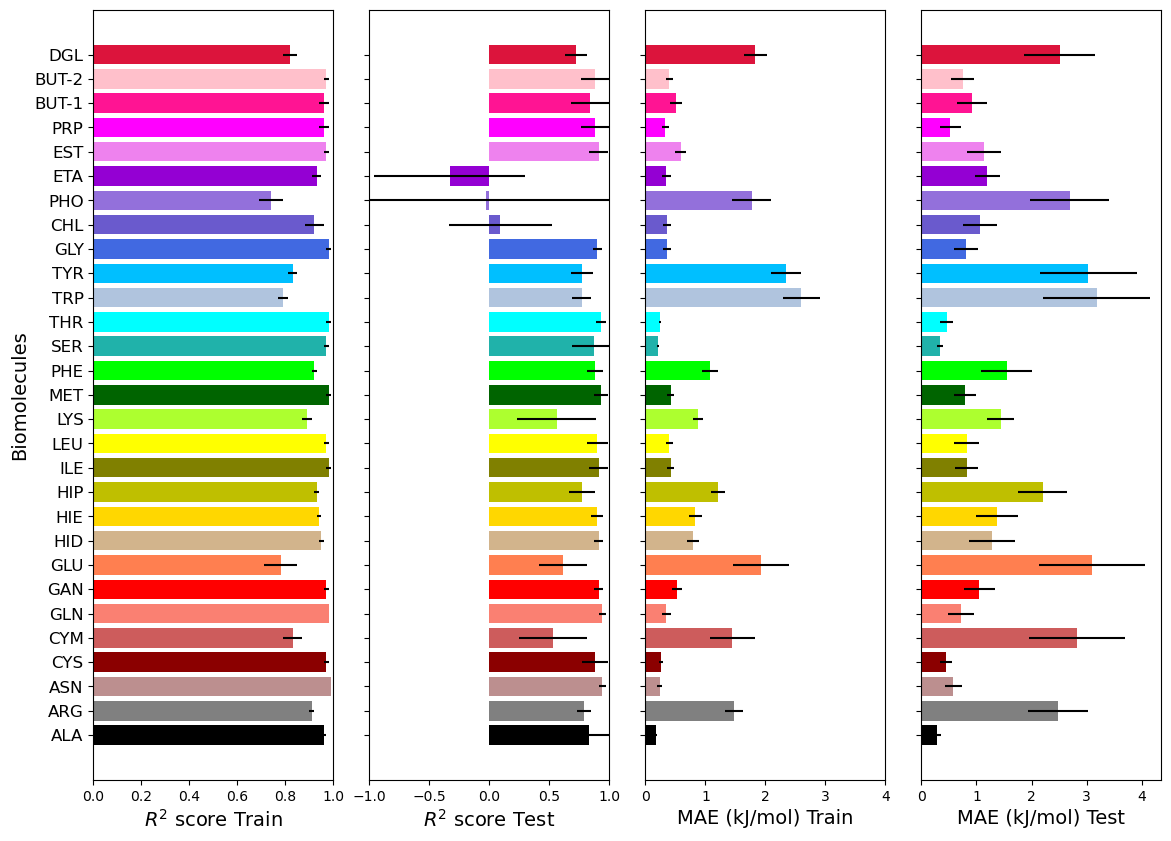

In [5]:
flatui = ["black","grey","rosybrown","darkred","indianred","salmon","red","coral","tan","gold","y","olive","yellow","greenyellow","darkgreen","lime","lightseagreen","aqua","lightsteelblue","deepskyblue","royalblue","slateblue","mediumpurple","darkviolet","violet","magenta","deeppink","pink","crimson"]
fig, ax = plt.subplots(1, 4, figsize=(12, 10),sharey=True)
fig.subplots_adjust(left=0.06, right=0.95, wspace=0.15)
df=pd.DataFrame(pd.read_csv('NN_result.csv',header=None, comment="#",sep='\s+',
                            squeeze=True, 
                            names=['AminoAcid', 'r2_avg_train', 'r2_std_train', 'r2_avg_test', 'r2_std_test', 'MAE_avg_train', 'MAE_std_train', 'MAE_avg_test', 'MAE_std_test']))
ax[0].barh(df.AminoAcid,df.r2_avg_train ,xerr= df.r2_std_train, color=flatui)
ax[0].set_xlabel('$R^2$ score Train',fontsize=14)
ax[0].set_yticklabels(df.AminoAcid, fontsize=12)
ax[0].set_xlim(0,1)

ax[1].barh(df.AminoAcid,df.r2_avg_test ,xerr= df.r2_std_test,color=flatui)
ax[1].set_xlabel('$R^2$ score Test',fontsize=14)
ax[1].set_xlim(-1,1)

ax[2].barh(df.AminoAcid,df.MAE_avg_train,xerr= df.MAE_std_train,color=flatui )
ax[2].set_xlabel('MAE (kJ/mol) Train',fontsize=14)
ax[2].set_xlim(0,4)

ax[3].barh(df.AminoAcid,df.MAE_avg_test,xerr= df.MAE_std_test,color=flatui)
ax[3].set_xlabel('MAE (kJ/mol) Test',fontsize=14);
ax[2].set_xlim(0,4)

ax[0].set_ylabel('Biomolecules',fontsize=14)
plt.savefig('NN_result.png', format='png', dpi=1000, bbox_inches='tight')

In [9]:
main=['ASP','VAL','PRO','ETA','PHO']

In [10]:
def AminoAcid_LR(i):
    X_LR=X[main]
    Y=X[i]
    rs = ShuffleSplit(n_splits=20, test_size=0.3, random_state=0)
    train_score=[]
    test_score=[]
    train_MAE=[]
    test_MAE=[]
    for train_index, test_index in rs.split(X_LR):  
        Xtrain=X_LR.iloc[list(train_index)]
        Ytrain=Y.iloc[list(train_index)]
        xtest=X_LR.iloc[list(test_index)]
        ytest=Y.iloc[list(test_index)]
        model = MLPRegressor(hidden_layer_sizes=(10), activation='tanh',alpha=0.001,solver='adam',random_state=10,
                  early_stopping=False,verbose=False,max_iter=2000) 
        model.fit(Xtrain,Ytrain)    
        Ytrain_pred=model.predict(Xtrain)
        ytest_pred=model.predict(xtest)
        train_score.append(np.round(model.score(Xtrain,Ytrain),2))
        test_score.append(np.round(model.score(xtest,ytest),2))
        train_MAE.append(mean_absolute_error(Ytrain,Ytrain_pred)) 
        test_MAE.append(mean_absolute_error(ytest,ytest_pred))
    return(np.round(np.average(train_score),2),np.round(np.std(train_score),2),
           np.round(np.average(test_score),2),np.round(np.std(test_score),2),
           np.round(np.average(train_MAE),2),np.round(np.std(train_MAE),2),
           np.round(np.average(test_MAE),2),np.round(np.std(test_MAE),2))

In [11]:
import warnings
warnings.simplefilter('ignore')
rest=[i for i in aminacid_order if i not in main ]
with open("NN_result_modify.csv", "w") as out_file: 
    out_file.write('#AminoAcid, r2_avg_train, r2_std_train, r2_avg_test, r2_std_test, MAE_avg_train, MAE_std_train, MAE_avg_test, MAE_std_test'+ '\n')
    for i in rest:
        r2_avg_train, r2_std_train, r2_avg_test, r2_std_test, MAE_avg_train, MAE_std_train, MAE_avg_test, MAE_std_test=AminoAcid_LR(i)
        out_file.write("%s %5.2f %5.2f %5.2f %5.2f %5.2f %5.2f %5.2f %5.2f\n" % (i, r2_avg_train, r2_std_train, r2_avg_test, r2_std_test, MAE_avg_train, MAE_std_train, MAE_avg_test, MAE_std_test)+ '\n')

/tmp/ipykernel_28684/3291308028.py:7: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  df=pd.DataFrame(pd.read_csv('NN_result_modify.csv',header=None, comment="#",sep='\s+',
/tmp/ipykernel_28684/3291308028.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(df.AminoAcid, fontsize=12)


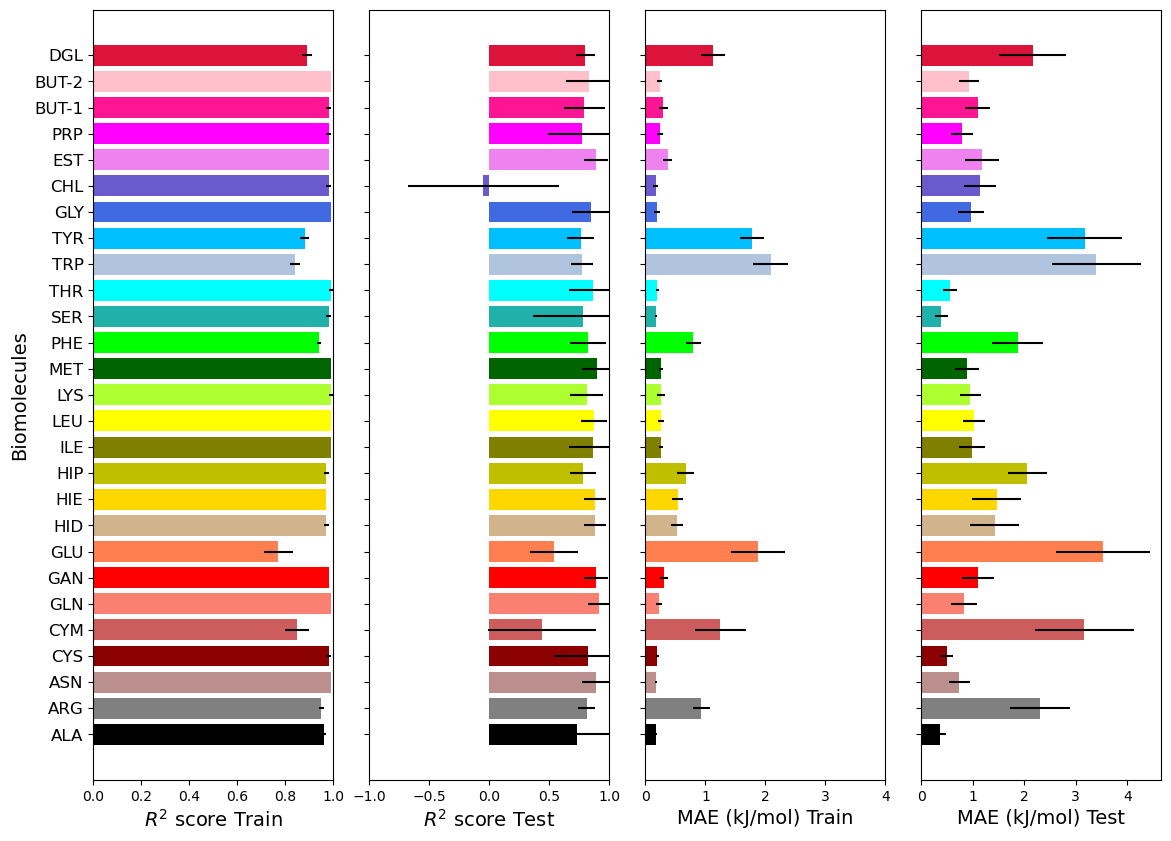

In [6]:
flatui = ["black","grey","rosybrown","darkred","indianred","salmon","red","coral","tan","gold","y","olive","yellow",
          "greenyellow","darkgreen","lime","lightseagreen","aqua","lightsteelblue","deepskyblue","royalblue",
          "slateblue","violet","magenta","deeppink","pink","crimson"]

fig, ax = plt.subplots(1, 4, figsize=(12, 10),sharey=True)
fig.subplots_adjust(left=0.06, right=0.95, wspace=0.15)
df=pd.DataFrame(pd.read_csv('NN_result_modify.csv',header=None, comment="#",sep='\s+',
                            squeeze=True, 
                            names=['AminoAcid', 'r2_avg_train', 'r2_std_train', 'r2_avg_test', 'r2_std_test', 'MAE_avg_train', 'MAE_std_train', 'MAE_avg_test', 'MAE_std_test']))
ax[0].barh(df.AminoAcid,df.r2_avg_train ,xerr= df.r2_std_train, color=flatui)
ax[0].set_xlabel('$R^2$ score Train',fontsize=14)
ax[0].set_yticklabels(df.AminoAcid, fontsize=12)
ax[0].set_xlim(0,1)

ax[1].barh(df.AminoAcid,df.r2_avg_test ,xerr= df.r2_std_test,color=flatui)
ax[1].set_xlabel('$R^2$ score Test',fontsize=14)
ax[1].set_xlim(-1,1)
ax[2].barh(df.AminoAcid,df.MAE_avg_train,xerr= df.MAE_std_train,color=flatui )
ax[2].set_xlabel('MAE (kJ/mol) Train',fontsize=14)
ax[2].set_xlim(0,4)
ax[3].barh(df.AminoAcid,df.MAE_avg_test,xerr= df.MAE_std_test,color=flatui)
ax[3].set_xlabel('MAE (kJ/mol) Test',fontsize=14);
ax[2].set_xlim(0,4)

ax[0].set_ylabel('Biomolecules',fontsize=14)
plt.savefig('NN_result_modify.png', format='png', dpi=1000, bbox_inches='tight')

# Predicted vs Real vales for testing data set (one of 10)

In [22]:
main=['ASP','VAL','PRO','ETA','PHO']
rest=[i for i in aminacid_order if i not in main ]
X_LR=X[main]
def Mary_pred(i):    
        Y=X[i]
        Xtrain,xtest,Ytrain,ytest=train_test_split(X_LR,Y,test_size=0.3, random_state=130)
        model = MLPRegressor(hidden_layer_sizes=(10), activation='tanh',alpha=0.1,solver='adam',random_state=10,
                  early_stopping=False,verbose=False,max_iter=10000) 
        model.fit(Xtrain,Ytrain)
        ytest_pred=model.predict(xtest)
        test_score=np.round(model.score(xtest,ytest),2)
        d = {'Aminoacid':i ,'Predict':list(ytest_pred),'Real':list(ytest), 'score':test_score, 'Method':'NN'}
        return(d)

In [23]:
df_list=[]
for i in rest:
    df= pd.DataFrame.from_dict(Mary_pred(i))
    df_list.append(df)        
result=pd.concat(df_list, ignore_index=True)
result.to_csv('NN_ypredict-yreal.csv')